# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Install packages
Only need to run when not in the virtual environment

In [1]:
%%bash

# Check if not in a Python virtual environment
if [[ -z "$VIRTUAL_ENV" ]]
then
    # Check if the requirements.txt file exists
    if [ -f requirements.txt ]
    then
        echo "Found requirements.txt, starting to install dependencies..."
        
        # Here you would typically use bash pip command as the magic command %pip won't work in bash cell
        pip install -r requirements.txt --quiet --no-cache-dir --disable-pip-version-check
    else
        echo "requirements.txt not found, please ensure the file is in the current directory."
    fi
fi

## Function definitions

#### Define Utility Functions

In [2]:
from collections.abc import Generator, Sequence
from os import path, getcwd, listdir, makedirs


def read_file_lines_from(file_path: str, /) -> Generator[str, None, None]:
    """
    Read lines from a file and yield each line as a string.
    The path to the file is relative to the current working directory.

    Args:
        file_path (str): The path to the file to be read.

    Yields:
        str: Each line of the file, stripped of leading and trailing whitespace.
    """
    full_path = path.join(getcwd(), file_path)
    buffer_size = 1024 * 1024
    with open(full_path, 'r', buffering=buffer_size, encoding='utf8') as file:
        for line in file:
            yield line.strip()


def write_file_lines_to(file_path: str, /, *, lines: Sequence[str]) -> None:
    """
    Write a sequence of lines to a file.

    Args:
        file_path (str): The path to the file.
        lines (Sequence[str]): A sequence of strings representing the lines to be written.
    """
    full_path = path.join(getcwd(), file_path)
    buffer_size = 1024 * 1024
    with open(full_path, 'w', buffering=buffer_size) as file:
        for line in lines:
            file.write(f"{line}\n")


def ls(dir_path: str, /) -> tuple[str, ...]:
    """
    List all files and directories in the specified directory.
    """
    full_path = path.join(getcwd(), dir_path)
    return tuple(listdir(full_path))


def mkdir(dir_path: str, /) -> None:
    """
    Create a directory.
    """
    full_path = path.join(getcwd(), dir_path)
    if not path.exists(full_path):
        makedirs(full_path)


def path_exists(location: str, /) -> bool:
    """
    Check if the specified path exists.
    """
    full_path = path.join(getcwd(), location)
    return path.exists(full_path)


def without_ext(file_name: str, /) -> str:
    """
    Returns the file name without the extension.

    Example:
    >>> without_ext("example.txt")
    'example'
    """
    return path.splitext(file_name)[0]

In [3]:
from collections.abc import Callable
from threading import Thread, Lock
from typing import final


@final
class BackgroundTask:
    """
    Represents a background task that can be executed concurrently.

    Args:
        task (Callable): The function or method to be executed as a background task.
        *args: Variable length argument list to be passed to the task.
        **kwargs: Arbitrary keyword arguments to be passed to the task.
    """

    def __init__(self, task: Callable[..., None], *args, **kwargs):
        self.__task = Thread(
            target=task,
            args=args,
            kwargs=kwargs,
            daemon=True
        )
        with Lock():
            self.__task.start()

    def wait(self) -> None:
        """
        Waits for the background task to complete.
        """
        return self.__task.join()

In [4]:
def unzip_file_to(file_path: str, /, destination: str) -> None:
    """
    Unzip a file to a specified destination.

    Args:
        file_path (str): The path to the file to be unzipped.
        destination (str): The path to the directory where the file will be unzipped.
    """
    import zipfile
    full_path = path.join(getcwd(), file_path)
    with zipfile.ZipFile(full_path, 'r') as zip_ref:
        zip_ref.extractall(destination)

In [5]:
from typing import Any, Final, Optional
from shelve import open as shelve_open


class GlobalCache:
    """
    A simple global cache for storing data in memory.
    """

    __runtime_cache: Final[dict[str, Any]] = {}
    __cache_file_name: Final[str] = 'cache'

    def put(self, key: str, value: object, /) -> None:
        """
        Put a value into the cache.

        Args:
            key (str): The key to be used to store the value.
            value (object): The value to be stored.
        """

        self.__runtime_cache[key] = value
        with shelve_open(self.__cache_file_name, 'c') as cache:
            cache[key] = value

    def get(self, key: str, /) -> Optional[Any]:
        """
        Get a value from the cache.

        Args:
            key (str): The key to be used to retrieve the value.

        Returns:
            object: The value stored in the cache.
        """

        if key in self.__runtime_cache:
            return self.__runtime_cache[key]

        with shelve_open(self.__cache_file_name, 'c') as cache:
            return cache.get(key)

    def remove(self, key: str, /) -> None:
        """
        Remove a value from the cache.

        Args:
            key (str): The key to be used to remove the value.
        """

        self.__runtime_cache.pop(key, None)
        with shelve_open(self.__cache_file_name, 'c') as cache:
            del cache[key]

    def clear(self) -> None:
        """
        Clear the cache.
        """

        self.__runtime_cache.clear()
        with shelve_open(self.__cache_file_name, 'c') as cache:
            cache.clear()

In [6]:
import skops.io as sio
from sklearn.base import BaseEstimator
from torch import save, load
from torch.nn import Module


def preserve_sklearn_model(model: BaseEstimator, /, *, file_path: str) -> None:
    """
    Save a scikit-learn model to a file.

    Args:
        model (Any): The scikit-learn model to be saved.
        file_path (str): The path to the file where the model will be saved.
    """
    full_path = path.join(getcwd(), file_path)

    print(">>> Saving model to:", full_path)
    sio.dump(model, file=full_path)
    print(">>> Model saved successfully!")


def load_sklearn_model_from(file_path: str, /) -> BaseEstimator:
    """
    Load a scikit-learn model from a file.

    Args:
        file_path (str): The path to the file where the model is saved.

    Returns:
        Any: The scikit-learn model loaded from the file.
    """
    full_path = path.join(getcwd(), file_path)

    print(">>> Loading model from:", full_path)
    model = sio.load(file=full_path, trusted=True)
    print(">>> Model loaded successfully!")
    return model


def preserve_torch_model(model: Module, /, *, file_path: str) -> None:
    """
    Save a PyTorch model to a file.

    Args:
        model (Module): The PyTorch model to be saved.
        file_path (str): The path to the file where the model will be saved.
    """
    full_path = path.join(getcwd(), file_path)

    print(">>> Saving model to:", full_path)
    save(model, full_path)
    print(">>> Model saved successfully!")


def load_torch_model_from(file_path: str, /) -> Module:
    """
    Load a PyTorch model from a file.

    Args:
        just_inited_model (Module): A PyTorch model that has just been initialized.
        file_path (str): The path to the file where the model is saved.
    """
    full_path = path.join(getcwd(), file_path)

    print(">>> Loading model from:", full_path)
    model = load(full_path)
    print(">>> Model loaded successfully!")

    return model

#### Package imports for Application logic

In [7]:
import pandas as pd
import numpy as np
import csv
import regex as re
import contractions
import torch
import matplotlib.pyplot as plt
import fasttext

from os import cpu_count
from typing import Final, final
from types import NoneType
from itertools import chain
from string import punctuation, digits
from functools import lru_cache
from concurrent.futures import ProcessPoolExecutor, as_completed
from enum import Enum
from collections import Counter, OrderedDict
from collections.abc import Sequence
from copy import copy
from huggingface_hub import hf_hub_download
from emoji import demojize
from nltk.downloader import download as nltk_download
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from scipy.sparse import csr_matrix
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel, BertConfig, get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import colormaps

#### Define global instances

<p><b>For TA:</b></p>
<style>.rainbow{text-align:center;text-decoration:underline;font-weight:bold}.rainbow_text_animated{background:linear-gradient(to right,#66f,#09f ,#0f0,#f39,#66f);-webkit-background-clip:text;background-clip:text;color:transparent;animation:.3s ease-in-out infinite rainbow_animation;background-size:400% 100%}@keyframes rainbow_animation{0%,100%{background-position:0 0}50%{background-position:100% 0}}</style>
<h1 class="rainbow rainbow_text_animated">⬇︎⬇︎⬇︎ Add Test File names HERE!! ⬇︎⬇︎⬇︎</h1>

In [8]:
# ▲ Enable this flag to allow training the models ▲
should_train_models: Final[bool] = True

# ▲ Allow training the SVM model, time: ~1s ▲
should_train_svm: Final[bool] = True

# ▲ Allow training the Logistic Regression model, time: ~1s ▲
should_train_logistic: Final[bool] = True

# ▲ Allow training the LSTM model, time: ~3m ▲
should_train_lstm: Final[bool] = True

# ▲ Allow training the BERT model, time: ~15m ▲
should_train_bert: Final[bool] = True

# names of the test set files
test_set_names: Final[tuple[str, ...]] = (
    'twitter-test1.txt',
    'twitter-test2.txt',
    'twitter-test3.txt',
    # ▲ All test files should be placed in the './{dataset_base_path}' directory ▲
    # ========================================================
    # ⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎⬇︎
    # 'twitter-test4.txt',
    # 'twitter-test5.txt',
    # 'twitter-test6.txt',
    # 'twitter-test7.txt',
    #   ................
    # ⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎⬆︎
    # ========================================================
)
training_data_file_name: Final[str] = 'twitter-training-data.txt'
devlopment_data_file_name: Final[str] = 'twitter-dev-data.txt'

dataset_base_path: Final[str] = 'data'
glove_data_dir: Final[str] = f"{dataset_base_path}/glove"
target_glove_file_name: Final[str] = "glove.6B.100d.txt"
target_bert_model_name: Final[str] = 'bert-base-multilingual-uncased'

# ▲ Pre-trained model names ▲
svm_model_save_path: Final[str] = 'svm_model.model'
logistic_model_save_path: Final[str] = 'logistic_model.model'
lstm_model_save_path: Final[str] = 'lstm_model.model'
bert_model_save_path: Final[str] = 'bert_model.model'

numbers_of_test_sets = len(test_set_names)


@final
class Sentiment(Enum):
    """
    An enumeration of the three possible sentiment values.
    """
    neutral = 0
    negative = 1
    positive = 2

    @classmethod
    @lru_cache
    def gts(cls) -> tuple[str, ...]:
        return tuple(cls.__members__.keys())


global_cache = GlobalCache()

TweetID = str
ShouldMarkedAsBackground = NoneType

#### Define data retrieval functions

In [9]:
@lru_cache(typed=True)
def get_tweets_from(file_name_: str, /) -> tuple[dict[TweetID, str], tuple[Sentiment, ...]]:
    """
    Read tweets from a file and return dictionaries containing tweet IDs, contents, and sentiments.

    Parameters:
    - file_name_ (str): The name of the file to read tweets from.

    Returns:
    - A tuple containing two dictionaries:
        - id_gts (dict[TweetID, str]): A dictionary mapping tweet IDs to their contents.
        - id_sentiments (dict[TweetID, Sentiment]): A dictionary mapping tweet IDs to their sentiments.
    """
    id_gts: OrderedDict[TweetID, str] = OrderedDict()
    sentiments: list[Sentiment] = []
    lines = read_file_lines_from(f'{dataset_base_path}/{file_name_}')
    for line in lines:
        fields = line.split('\t')
        tweet_id = fields[0]
        gt = fields[1]
        content = ' '.join(fields[2:])
        id_gts[tweet_id] = content
        sentiments.append(Sentiment[gt])

    return id_gts, tuple(sentiments)

#### Define GloVe data preparation functions

In [10]:
def prepare_glove_data() -> ShouldMarkedAsBackground:
    if path_exists(glove_data_dir) and len(ls(glove_data_dir)) == 4:
        return

    glove_data_pack_name = 'glove.6B.zip'

    hf_hub_download(
        repo_id='stanfordnlp/glove',
        filename=glove_data_pack_name,
        local_dir=dataset_base_path,
        revision='1db2080b2d94def6e5b0386a523102f9d8849e9d',
    )

    # perform shell command using python code since the thread management can be done in python.
    mkdir(glove_data_dir)
    unzip_file_to(
        f'{dataset_base_path}/{glove_data_pack_name}',
        destination=glove_data_dir
    )

In [11]:
@lru_cache(typed=True)
def parse_glove_data(file_name_: str) -> tuple[dict[str, int], np.ndarray]:
    """
    Parse the GloVe data from a given file.

    Args:
        file_name_ (str): The name of the file containing the GloVe data.

    Returns:
        tuple[dict[str, int], np.ndarray]: A tuple containing two elements:
            - A dictionary mapping words to their corresponding indices.
            - A numpy array containing the word vectors.
    """
    file_frame = pd.read_csv(
        f"{glove_data_dir}/{file_name_}",
        delimiter=' ',
        quoting=csv.QUOTE_NONE,
        header=None,
        encoding='utf-8',
        skip_blank_lines=True,
    )
    
    vectors = file_frame.iloc[:, 1:].to_numpy(dtype=np.float64)
    
    # Add a custom <pad> to the top of the vectors
    vectors = np.insert(vectors, 0, np.zeros(vectors.shape[1]), axis=0)

    return (
        file_frame.reset_index().set_index(0)['index'].to_dict(),
        vectors
    )

#### Define data preprocessing functions

In [12]:
def filter_text(src: str, /, *, patterns: Sequence[re.Pattern]) -> str:
    """
    Filters the given source text by removing all occurrences of the specified patterns.

    Args:
        src (str): The source text to be filtered.
        patterns (Sequence[Pattern]): A sequence of regular expression patterns to be removed from the source text.

    Returns:
        str: The filtered text with all occurrences of the specified patterns removed.
    """
    filtered = copy(src)

    for pattern in patterns:
        filtered = pattern.sub('', filtered)

    return filtered


def process_texts(src_dict: dict[Any, str], callable: Callable, *args, **kwargs) -> dict[Any, str]:
    """
    Process a dictionary of texts using a callable function in parallel using a thread pool executor.

    Args:
        src_dict (dict[Any, str]): A dictionary containing the texts to be processed.
        callable (Callable[[str], Any]): A callable function that will be applied to each text.
        *args: Variable length argument list to be passed to the callable function.
        **kargs: Arbitrary keyword arguments to be passed to the callable function.

    Returns:
        dict[Any, str]: A dictionary containing the processed texts.
    """

    multi_process = False

    if multi_process:
        with ProcessPoolExecutor(max_workers=(cpu_count() or 1)) as executor:
            future_to_key = {
                executor.submit(callable, src_dict[key], *args, **kwargs): key for key in src_dict
            }
            return {
                future_to_key[future]: future.result()
                for future in as_completed(future_to_key)
            }

    return {
        key: callable(value, *args, **kwargs)
        for key, value in src_dict.items()
    }


def run_pipelines(
    callables: Sequence[Callable[[str], str]],
    /,
    *,
    tweets: dict[TweetID, str]
) -> dict[str, str]:
    """
    Run a sequence of callables on a dictionary of texts in parallel using a thread pool executor.

    Args:
        callables (Sequence[Callable[[dict[str, str]], dict[str, str]]]): A sequence of callable functions to be applied to the dictionary of texts.
        tweets (dict[str, str]): A dictionary containing the texts to be processed.

    Returns:
        dict[str, str]: A dictionary containing the processed texts.
    """
    processed = copy(tweets)

    for callable in callables:
        processed = process_texts(processed, callable)

    return processed

#### Define sklearn presentation convenience functions

In [13]:
def prepare_presentation_from(
    *,
    predict_results: dict[TweetID, Sentiment],
    test_set_file_name_: str
) -> tuple[list[int], list[int], list[int]]:
    id_tweets, sentiments = get_tweets_from(test_set_file_name_)

    labels = [sentiment.value for sentiment in Sentiment]
    y_test = [sentiment.value for sentiment in sentiments]
    y_pred = [
        predict_results.get(tweet_id, Sentiment.neutral).value
        for tweet_id in id_tweets
    ]

    return y_test, y_pred, labels

#### Define confusion matrix function

In [14]:
def show_confusion(*, predict_results: dict[TweetID, Sentiment], test_set_file_name_: str) -> None:
    """
    Display the confusion matrix based on the predicted results and the sentiment labels from the test set file.

    Args:
        predict_results (dict[TweetID, Sentiment]): A dictionary containing the predicted sentiment for each tweet ID.
        test_set_file_name_ (str): The file name of the test set containing the sentiment labels for each tweet ID.
    """
    y_test, y_pred, labels = prepare_presentation_from(
        predict_results=predict_results,
        test_set_file_name_=test_set_file_name_
    )

    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=Sentiment.gts()
    )

    disp.plot(cmap=colormaps['Blues'])
    plt.show()

#### Define evaluation functions

In [15]:
def evaluate(predict_results: dict[TweetID, Sentiment], test_set_file_name_: str, classifier_name_: str) -> None:
    """
    Evaluate the performance of a sentiment classifier by comparing the predicted results with the ground truth sentiment labels.

    Parameters:
        - predict_results: A dictionary mapping TweetIDs to predicted Sentiments.
        - test_set_file_name_: The name of the test set file.
        - classifier_name_: The name of the classifier.
    """
    y_test, y_pred, labels = prepare_presentation_from(
        predict_results=predict_results,
        test_set_file_name_=test_set_file_name_
    )

    sem_eval_macro_f1 = f1_score(
        y_test,
        y_pred,
        labels=labels,
        average='macro'
    )

    print(
        f"{test_set_file_name_} ({classifier_name_}) "
        f"F1-macro: {sem_eval_macro_f1:.3f}"
    )

## Resource loading

#### Load training set, dev set and testing set

In [16]:
training_data, training_sentiments = get_tweets_from(training_data_file_name)
dev_data, dev_sentiments = get_tweets_from(devlopment_data_file_name)
test_datas, test_sentiments = zip(*[
    get_tweets_from(file_name)
    for file_name in test_set_names
])

#### Download network resources

In [17]:
glove_prepare_task = BackgroundTask(prepare_glove_data)


def download_nltk_resources(resource_names: Sequence[str]) -> ShouldMarkedAsBackground:
    for resource_name in resource_names:
        nltk_download(resource_name, quiet=True)


nltk_prepare_task = BackgroundTask(
    download_nltk_resources,
    ('stopwords', 'vader_lexicon', 'punkt', 'wordnet',)
)


def pre_load_bert_tokenizer() -> ShouldMarkedAsBackground:
    BertTokenizer.from_pretrained(target_bert_model_name)
    BertModel.from_pretrained(target_bert_model_name)


bert_prepare_task = BackgroundTask(pre_load_bert_tokenizer)

## Data Preprocessing

#### Lowercase the tweets

In [18]:
# Lowercase all the words.

def lowercase_tweet(tweet: str, /) -> str:
    return tweet.lower()

#### Regexp filter

In [19]:
# Filter the tweets based on the selected regexp patterns.

re_flags = re.IGNORECASE | re.MULTILINE

pattern_html_tags = re.compile(r'<[^>]+?>', re_flags)
pattern_mentions = re.compile(r'@[a-zA-Z0-9_]+', re_flags)
pattern_hashtags = re.compile(r'#[a-zA-Z0-9_]+', re_flags)
pattern_alphanumeric = re.compile(r'[^a-zA-Z0-9 ]+?', re_flags)
pattern_only_one_char = re.compile(r'\b[a-zA-Z0-9]\b', re_flags)
pattern_fully_numeric = re.compile(r'\b([0-9]+)\b', re_flags)

pattern_punctuation = re.compile(
    "[" + re.escape(punctuation+"“”…‘’") + "]+?",
    re_flags
)
custom_removal_puncuations = punctuation+'“”…‘’'
punctuation_translator = str.maketrans(
    custom_removal_puncuations,
    ' ' * len(custom_removal_puncuations)
)

pattern_url = re.compile(
    r'(?:[a-zA-Z][a-zA-Z0-9+-.]*:)?'
    r'(//(?:[a-zA-Z0-9-._~%!$&\'()*+,;=:]*(?::[a-zA-Z0-9-._~%!$&\'()*+,;=:]+)?@)?'
    r'(?:\[[0-9a-fA-F:.]+]|(?:[a-zA-Z0-9-]+\.)*[a-zA-Z]{2,}|[0-9.]+|localhost)'
    r'(?::\d+)?)(/[a-zA-Z0-9-._~%!$&\'()*+,;=:@]*/?)*'
    r'(?:\?[a-zA-Z0-9-._~%!$&\'()*+,;=:@/]*)?'
    r'(?:#[a-zA-Z0-9-._~%!$&\'()*+,;=:@/]*)?',
    re_flags
)

# all_emojis = tuple(EMOJI_DATA.keys())
# pattern_emojis = re.compile('|'.join(map(re.escape, all_emojis)) + '?')

pattern_ampm = re.compile(r'([0-9]+(am|pm))')
pattern_ordinals = re.compile(r'([0-9]+)(?:st|nd|rd|th)')

selected_filter_patterns: tuple[re.Pattern[str], ...] = (
    pattern_url,
    pattern_html_tags,
    pattern_mentions,
    pattern_hashtags,
    pattern_fully_numeric,
    pattern_only_one_char,
    pattern_ampm,
    pattern_ordinals,
)


def regexp_filter(tweet: str, /) -> str:
    return filter_text(tweet, patterns=selected_filter_patterns)


def punctuation_filter(tweet: str, /) -> str:
    return tweet.translate(punctuation_translator)

#### Remove emojis

In [20]:
def remove_emojis(tweet: str, /) -> str:
    return demojize(tweet, delimiters=('', ''))

#### Remove numbers

In [21]:
remove_digits = str.maketrans('', '', digits)


def remove_numbers(tweet: str, /) -> str:
    return tweet.translate(remove_digits)

#### Remove non-English words

In [22]:
from langdetect import detect

def remove_non_en(tweet: str, /) -> str:
    try:
        if detect(tweet) == 'en':
            return tweet
        else:
            return ''
    except:
        return ''

#### Tokenization & Lemmatization

In [23]:
nltk_prepare_task.wait()

lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer(
    reduce_len=True,
    strip_handles=True,
    preserve_case=False
)

custom_preserved_words: frozenset[str] = frozenset((
    'not', "wouldn't", 'nor',
    'but', "weren't", 'couldn',
    'didn', 'doesn', 'hadn',
    'hasn', 'haven', 'isn', 'mightn',
    "aren't", 'mustn', 'needn',
    "shan't", 'shouldn', 'wasn',
    "mustn't", "didn't", "doesn't",
    "mightn't", "isn't", "shouldn't",
    "mustn't", "haven", "isn",
    "didn't", "aren't", "wouldn't",
    "shouldn't", "couldn't", "hadn't",
    "don't", "won't", "can't",
    "hasn't", "wasn't", 'the'
))
custom_stop_words: frozenset[str] = frozenset((
    "call", 'upon', 'still', 'nevertheless', 
    'down', 'every', 'forty', '‘re', 'always', 
    'whole', 'side', 'now', 'however', 
    'an', 'show', 'least', 'give', 'below', 
    'did', 'sometimes', 'which', "'s", 
    'nowhere', 'per', 'hereupon', 'yours', 
    'she', 'moreover', 'eight', 'somewhere', 
    'within', 'whereby', 'few', 'has', 'so', 
    'have', 'for', 'noone', 'top', 'were', 
    'those', 'thence', 'eleven', 'after', 
    '’ll', 'others', 'ourselves', 
    'themselves', 'though', 'that', 'just', '’s', 
    'before', 'had', 'toward', 'another', 'should', 
    'herself', 'and', 'these', 'such', 'elsewhere',
    'further', 'next', 'indeed', 'bottom', 'anyone',
    'his', 'each', 'then', 'both', 'became', 'third',
    'whom', '‘ve', 'mine', 'take', 'many', 'anywhere',
    'to', 'well', 'thereafter', 'besides', 'almost',
    'front', 'fifteen', 'towards', 'be', 'herein',
    'two', 'using', 'whatever', 'please', 'perhaps',
    'full', 'ca', 'we', 'latterly', 'here', 'therefore',
    'us', 'how', 'was', 'made', 'or', 'may', '’re',
    'namely', "'ve", 'anyway', 'amongst', 'used', 'ever',
    'of', 'there', 'than', 'why', 'really', 'whither', 'in',
    'only', 'wherein', 'last', 'under', 'own', 'therein',
    'go', 'seems', '‘m', 'wherever', 'either', 'someone',
    'up', 'doing', 'on', 'rather', 'ours', 'again', 'same',
    'over', '‘s', 'latter', 'during', 'done', "'re", 
    'put', "'m", 'much', 'among', 'seemed', 'into', 
    'once', 'my', 'otherwise', 'part', 'everywhere',
    'myself', 'must', 'will', 'am', 'although',
    'as', 'beyond', 'are', 'too', 'becomes', 'does', 
    'a', 'everyone', 'some', 'regarding', '‘ll', 
    'throughout', 'yourselves', 'him', "'d", 'it',
    'himself', 'whether', 'move', '’m', 'hereafter',
    're', 'while', 'whoever', 'your', 'first', 'amount',
    'twelve', 'serious', 'other', 'any', 'off', 'seeming',
    'four', 'itself', 'nothing', 'beforehand', 'make', 'out',
    'very', 'already', 'various', 'until', 'hers', 'they', 
    'them', 'where', 'would', 'since', 'everything', 'at', 
    'together', 'yet', 'more', 'six', 'back', 'with', 'thereupon',
    'becoming', 'around', 'due', 'keep', 'somehow', 'across',
    'all', 'when', 'i', 'empty', 'nine', 'five', 'get', 'see',
    'been', 'name', 'between', 'hence', 'ten', 'several', 'from',
    'whereupon', 'through', 'hereby', "'ll", 'alone', 'something',
    'formerly','above', 'onto', 'except', 'enough', 'become', 
    'behind', '’d', 'its', 'most', 'n’t', 'might', 'whereas',
    'anything', 'if', 'her', 'via', 'fifty', 'is', 'thereby', 
    'twenty', 'often', 'whereafter', 'their', 'also', 'anyhow', 
    'our', 'could', 'because', 'who', 'beside', 'by', 'whence', 
    'being', 'meanwhile', 'this', 'afterwards', 'whenever', 'mostly',
    'what', 'one', 'nobody', 'seem', 'do', '‘d', 'say',
    'thus', 'unless', 'along', 'yourself', 'former', 'thru',
    'he', 'hundred', 'three', 'sixty', 'me', 'sometime', 'amp',
    'whose', 'you', 'quite', '’ve', 'about', 'even',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
    'saturday', 'sunday', 'january', 'february', 'march', 'april',
    'may', 'june', 'july', 'august', 'september', 'october',
    'november', 'december'
))
stop_words = (frozenset(stopwords.words('english')) | custom_stop_words) - custom_preserved_words


def nltk_tokenize_anti_stopwords_lemmatize(tweet: str, /) -> str:
    wordnet.ensure_loaded()
    tokens = tokenizer.tokenize(tweet)
    return ' '.join(
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    )

#### Fix contractions

In [24]:
def fix_contractions(tweet: str, /) -> str:
    return f'{contractions.fix(tweet)}'

#### Run all preprocessing steps

In [25]:
all_pipelines = (
    lowercase_tweet,
    fix_contractions,
    regexp_filter,
    remove_emojis,
    remove_numbers,
    punctuation_filter,
    nltk_tokenize_anti_stopwords_lemmatize,
)

cleaned_training_tweets = run_pipelines(
    all_pipelines,
    tweets=training_data
)

cleaned_dev_tweets = run_pipelines(
    all_pipelines,
    tweets=dev_data
)

cleaned_test_tweets = [
    run_pipelines(
        all_pipelines,
        tweets=test_data
    )
    for test_data in test_datas
]

#### Show the top 10 most frequent words in the training set

In [26]:
all_words = ' '.join(cleaned_training_tweets.values()).split()
word_freq = Counter(all_words)

freq_frame = pd.DataFrame(
    word_freq.most_common(20),
    columns=['word', 'freq']
)

print(freq_frame)

        word   freq
0        the  34055
1        not   6834
2   tomorrow   5911
3        but   3702
4        day   3650
5      going   3282
6      night   2558
7       like   2405
8       time   2367
9       want   1848
10       new   1699
11      game   1666
12      know   1481
13     today   1443
14      good   1364
15     think   1252
16   tonight   1240
17      come   1230
18    cannot   1157
19      love   1132


#### Save preprocessed data to file

In [27]:
def write_tweets_to_file(
    file_name_: str,
    /,
    *,
    tweets: dict[TweetID, str],
    sentiments: Sequence[Sentiment]
) -> ShouldMarkedAsBackground:
    write_file_lines_to(
        file_name_,
        lines=[
            f"__label__{sentiment.name} {tweet}"
            for (_, tweet), sentiment in zip(tweets.items(), sentiments)
        ]
    )


preprocessed_training_data_file_name = f"{
    without_ext(training_data_file_name)
}.cleaned"

# Currently we only write training data to file,
# because only FastText model is trained using a file.
write_preprocessed_training_data_task = BackgroundTask(
    write_tweets_to_file,
    preprocessed_training_data_file_name,
    tweets=cleaned_training_tweets,
    sentiments=training_sentiments
)

## Vectorizations

#### TF-IDF Vectorization

In [28]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    encoding='utf-8',
    lowercase=False,
    min_df=3,
    max_df=0.8,
    max_features=4940,
    ngram_range=(1, 7)
)

tfidf_training_matrix = np.asarray(
    csr_matrix(
        tfidf_vectorizer.fit_transform(cleaned_training_tweets.values())
    ).todense()
)
tfidf_dev_matrix = np.asarray(
    csr_matrix(
        tfidf_vectorizer.transform(cleaned_dev_tweets.values())
    ).todense()
)
tfidf_test_matrices = [
    np.asarray(
        csr_matrix(
            tfidf_vectorizer.transform(test_data.values())
        ).todense()
    )
    for test_data in cleaned_test_tweets
]

#### FastText Embedding

In [29]:
write_preprocessed_training_data_task.wait()

fast_text_model = fasttext.train_supervised(
    input=preprocessed_training_data_file_name,
    minCount=3,
    ws=15,
    wordNgrams=3
)

fast_text_training_matrix = np.array(
    csr_matrix(
        [
            fast_text_model.get_sentence_vector(tweet)
            for tweet in cleaned_training_tweets.values()
        ]
    ).todense()
)

fast_text_dev_matrix = np.array(
    csr_matrix(
        [
            fast_text_model.get_sentence_vector(tweet)
            for tweet in cleaned_dev_tweets.values()
        ]
    ).todense()
)

fast_text_test_matrices = [
    np.array(
        csr_matrix(
            [
                fast_text_model.get_sentence_vector(tweet)
                for tweet in test_data.values()
            ]
        ).todense()
    )
    for test_data in cleaned_test_tweets
]

Read 0M words
Number of words:  11372
Number of labels: 3
Progress: 100.0% words/sec/thread: 1745459 lr:  0.000000 avg.loss:  0.527308 ETA:   0h 0m 0s


## Build sentiment classifiers

##### SVM

In [30]:
if should_train_models and should_train_svm:
    svm_model = LinearSVC(verbose=False, dual=False)
    svm_model.fit(
        tfidf_training_matrix,
        [sentiments.value for sentiments in training_sentiments]
    )

    preserve_sklearn_model(
        svm_model,
        file_path=svm_model_save_path
    )

    for x in range(numbers_of_test_sets):
        svm_predictions = svm_model.predict(tfidf_test_matrices[x])
        svm_report = classification_report(
            [sentiments.value for sentiments in test_sentiments[x]],
            svm_predictions,
            target_names=Sentiment.gts(),
            digits=5
        )

        print(svm_report)

>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/svm_model.model
>>> Model saved successfully!
              precision    recall  f1-score   support

     neutral    0.59484   0.78191   0.67567      1504
    negative    0.62171   0.33932   0.43902       557
    positive    0.72640   0.61769   0.66765      1470

    accuracy                        0.64373      3531
   macro avg    0.64765   0.57964   0.59411      3531
weighted avg    0.65385   0.64373   0.63500      3531

              precision    recall  f1-score   support

     neutral    0.54842   0.72795   0.62556       669
    negative    0.60909   0.33168   0.42949       202
    positive    0.75556   0.65784   0.70332       982

    accuracy                        0.64760      1853
   macro avg    0.63769   0.57249   0.58612      1853
weighted avg    0.66481   0.64760   0.64540      1853

              precision    recall  f1-score   support

     neutral    0.55296   0.77009   0.64371       983
   

#### Logistic Regression

In [31]:
if should_train_models and should_train_logistic:
    logistic_model = LogisticRegression(
        multi_class='multinomial'
    )

    logistic_model.fit(
        fast_text_training_matrix,
        [sentiments.value for sentiments in training_sentiments]
    )

    preserve_sklearn_model(
        logistic_model,
        file_path=logistic_model_save_path
    )

    for x in range(numbers_of_test_sets):
        logistic_predictions = logistic_model.predict(fast_text_test_matrices[x])
        logistic_report = classification_report(
            [sentiments.value for sentiments in test_sentiments[x]],
            logistic_predictions,
            target_names=Sentiment.gts(),
            digits=5
        )

        print(logistic_report)

>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/logistic_model.model
>>> Model saved successfully!
              precision    recall  f1-score   support

     neutral    0.60277   0.78191   0.68075      1504
    negative    0.71885   0.40395   0.51724       557
    positive    0.73481   0.63333   0.68031      1470

    accuracy                        0.66044      3531
   macro avg    0.68547   0.60640   0.62610      3531
weighted avg    0.67605   0.66044   0.65477      3531

              precision    recall  f1-score   support

     neutral    0.56257   0.74589   0.64139       669
    negative    0.70690   0.40594   0.51572       202
    positive    0.77882   0.67413   0.72271       982

    accuracy                        0.67080      1853
   macro avg    0.68276   0.60865   0.62661      1853
weighted avg    0.69291   0.67080   0.67078      1853

              precision    recall  f1-score   support

     neutral    0.55572   0.77620   0.64771       98

#### LSTM Classifier

In [32]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


##### GloVe Embedding Vectorization

In [33]:
@final
class GloVeVectorizer:
    def __init__(self, word_indexes: dict[str, int], word_vectors: np.ndarray):
        self.word_indexes = word_indexes
        self.word_vectors = word_vectors

    def __vectorize_impl(self, tokens: Sequence[str], /) -> np.ndarray:
        vecs = np.zeros(
            (len(tokens), self.word_vectors.shape[1]),
            dtype=np.float64
        )
        for i, token in enumerate(tokens):
            if token in self.word_indexes:
                vecs[i] = self.word_vectors[self.word_indexes[token]]
        return vecs

    def __ordinalization_impl(self, tokens: Sequence[str], /) -> np.ndarray:
        return np.asarray([
            self.word_indexes.get(token, 400001) # 400001 is the index of the <UNK> token.
            for token in tokens
        ])

    @staticmethod
    def __largest_element_count(element_sets: Sequence[Sequence | np.ndarray], /) -> int:
        return max(
            len(element)
            for element in element_sets
        )

    @staticmethod
    def __expand_2d_to_size(
        _2d_targets: Sequence[np.ndarray],
        /,
        *,
        size: int
    ) -> list[np.ndarray]:
        assert size > 0
        assert len(_2d_targets) > 0
        return [
            np.vstack((
                _2d_target,
                np.zeros(
                    (size - _2d_target.shape[0], _2d_target.shape[1]),
                    dtype=np.float64
                )
            ))
            for _2d_target in _2d_targets
        ]

    @staticmethod
    def __expand_1d_to_size(
        _1d_targets: Sequence[np.ndarray],
        /,
        *,
        size: int
    ) -> list[np.ndarray]:
        assert size > 0
        assert len(_1d_targets) > 0
        return [
            np.pad(
                _1d_target,
                (0, size - _1d_target.shape[0]),
                mode='constant',
                constant_values=0 # 0 is the index of the <PAD> token. (self added)
            )
            for _1d_target in _1d_targets
        ]

    def vectorize(self, tweets: dict[TweetID, str], /) -> np.ndarray:
        tokens = [
            self.__vectorize_impl(tweet.split())
            for tweet in tweets.values()
        ]
        return np.asarray(
            self.__expand_2d_to_size(
                tokens,
                size=self.__largest_element_count(tokens)
            )
        )

    def ordinalization(self, tweets: dict[TweetID, str], /) -> np.ndarray:
        indexes = [
            self.__ordinalization_impl(tweet.split())
            for tweet in tweets.values()
        ]
        return np.asarray(
            self.__expand_1d_to_size(
                indexes,
                size=self.__largest_element_count(indexes)
            ),
            dtype=np.int32
        )

##### Define LSTM model

In [34]:
class AttentionMechanism(torch.nn.Module):
    """
    A module that implements an attention mechanism.

    Args:
        hidden_size (int): The size of the hidden state.

    Attributes:
        hidden_size (int): The size of the hidden state.
        attention_weights (torch.Tensor): The attention weights.

    Methods:
        forward(lstm_output: torch.Tensor) -> torch.Tensor: Performs the forward pass of the attention mechanism.

    """

    def __init__(self, hidden_size: int) -> None:
        super(AttentionMechanism, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = torch.nn.Parameter(
            torch.Tensor(hidden_size, 1)
        )
        torch.nn.init.xavier_uniform_(self.attention_weights.data, gain=1.414)

    def forward(self, lstm_output: torch.Tensor) -> torch.Tensor:
        attention_scores = torch.matmul(lstm_output, self.attention_weights)
        attention_scores = attention_scores.squeeze(2)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_output = lstm_output * attention_weights.unsqueeze(2)
        return weighted_output.sum(1)


class SentimentLSTMModel(torch.nn.Module):
    """
    A sentiment analysis LSTM model.

    This model takes in a sequence of input tokens and predicts the sentiment of the input text.
    It consists of an embedding layer, a bidirectional LSTM layer, an attention mechanism, and a fully connected layer.

    Args:
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The dimension of the word embeddings.
        hidden_size (int): The size of the hidden state of the LSTM.
        output_size (int): The number of output classes.
        pretrained_embeddings (torch.Tensor): Pretrained word embeddings.

    Attributes:
        hidden_size (int): The size of the hidden state of the LSTM.
        embedding (torch.nn.Embedding): The embedding layer.
        lstm (torch.nn.LSTM): The bidirectional LSTM layer.
        attention (AttentionMechanism): The attention mechanism.
        fc (torch.nn.Linear): The fully connected layer.
        dropout (torch.nn.Dropout): The dropout layer.
    """

    def __init__(
        self,
        embedding_dim: int,
        hidden_size: int,
        output_size: int,
        pretrained_embeddings: torch.Tensor
    ):
        super(SentimentLSTMModel, self).__init__()

        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding.from_pretrained(
            embeddings=pretrained_embeddings,
            padding_idx=0,
            freeze=False
        )
        self.embedding.weight.requires_grad = False

        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=2,
            dropout=0.5,
            batch_first=True,
            bidirectional=True
        )

        self.attention = AttentionMechanism(hidden_size * 2)

        self.dropout = torch.nn.Dropout(0.5)

        self.fc = torch.nn.Linear(hidden_size * 2, output_size)
        
        self.batch_norm = torch.nn.BatchNorm1d(output_size)

    def forward(self, x: torch.Tensor, /) -> torch.Tensor:
        embedded = self.dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)
        attn_out = self.attention(lstm_out)
        out = self.fc(self.dropout(attn_out))
        return self.batch_norm(out)

##### Define LSTM model training and evaluation functions

In [35]:
def train_torch_model(
    model: torch.nn.Module,
    train_loader: DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> float:
    """Train the model for one epoch.

    Args:
        model: The neural network model.
        train_loader: DataLoader for the training dataset.
        loss_fn: The loss function.
        optimizer: The optimizer.
        device: The device to run the training on.

    Returns:
        The average loss for this training epoch.
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc="LSTM Training"):
        tweets, sentiments = batch
        optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(True), torch.cuda.amp.autocast():
            outputs = model(tweets)
            loss = loss_fn(outputs, sentiments)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    return average_loss


def evaluate_torch_model(
    model: torch.nn.Module,
    val_loader: DataLoader,
    loss_fn: torch.nn.Module,
) -> tuple[float, float]:
    """Evaluate the model performance on the validation set.

    Args:
        model: The neural network model.
        val_loader: DataLoader for the validation dataset.
        device: The device to run the evaluation on.

    Returns:
        A tuple of accuracy and the average loss on the validation set.
    """
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    for batch in tqdm(val_loader, desc="LSTM Evaluating"):
        tweets, sentiments = batch
        with torch.no_grad(), torch.cuda.amp.autocast():
            outputs = model(tweets)
            loss = loss_fn(outputs, sentiments)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += sentiments.size(0)
        correct += (predicted == sentiments).sum().item()

    accuracy = correct / total
    average_loss = total_loss / len(val_loader)
    return accuracy, average_loss

##### Get GloVe Embedding vector

In [36]:
glove_word_indexes: Optional[dict[str, int]] = global_cache.get("glove_word_indexes")
glove_word_vectors: Optional[np.ndarray] = global_cache.get("glove_word_vectors")

if (glove_word_indexes is None) or (glove_word_vectors is None):
    glove_prepare_task.wait()
    glove_word_indexes, glove_word_vectors = parse_glove_data(target_glove_file_name)

    try:
        global_cache.put("glove_word_indexes", glove_word_indexes)
        global_cache.put("glove_word_vectors", glove_word_vectors)
    except Exception as e:
        print(e)

##### Setup the model, loss function, and optimizer

In [37]:
assert glove_word_indexes is not None
assert glove_word_vectors is not None

glove_vectorizer = GloVeVectorizer(glove_word_indexes, glove_word_vectors)

training_glove_indexes = glove_vectorizer.ordinalization(
    cleaned_training_tweets
)

# Calculate how many tokens in the training set are not in the GloVe word vectors.
training_glove_tokens = np.count_nonzero(training_glove_indexes == 400001)
print(f"Training set tokens not in GloVe: {training_glove_tokens}")
print(len(training_glove_indexes))

dev_glove_indexes = glove_vectorizer.ordinalization(cleaned_dev_tweets)

test_glove_indexs = [
    glove_vectorizer.ordinalization(test_data)
    for test_data in cleaned_test_tweets
]

lstm_training_dataset = TensorDataset(
    torch.from_numpy(training_glove_indexes).to_dense().to(device),
    torch.tensor(
        [sentiments.value for sentiments in training_sentiments]
    ).to_dense().to(device)
)
lstm_dev_dataset = TensorDataset(
    torch.from_numpy(dev_glove_indexes).to_dense().to(device),
    torch.tensor(
        [sentiments.value for sentiments in dev_sentiments]
    ).to_dense().to(device)
)
lstm_test_datasets = [
    TensorDataset(
        torch.from_numpy(test_glove_index).to_dense().to(device),
        torch.tensor(
            [sentiments.value for sentiments in test_sentiments]
        ).to_dense().to(device)
    )
    for test_glove_index, test_sentiments in zip(
        test_glove_indexs,
        test_sentiments
    )
]

lstm_model = SentimentLSTMModel(
    embedding_dim=glove_word_vectors.shape[1],
    hidden_size=256,
    output_size=len(Sentiment.gts()),
    pretrained_embeddings=torch.from_numpy(glove_word_vectors).float()
).to(device)

lstm_loss_fn = torch.nn.CrossEntropyLoss(
    ignore_index=400001
).to(device)
lstm_optimizer = torch.optim.AdamW(
    lstm_model.parameters(),
    lr=1e-2,
    weight_decay=1e-4
)

print(lstm_model)

Training set tokens not in GloVe: 8298
45101
SentimentLSTMModel(
  (embedding): Embedding(400002, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): AttentionMechanism()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (batch_norm): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


##### train the model

In [38]:
epochs = 20
batch_size = 512
workers = cpu_count() or 1

lstm_training_loader = DataLoader(
    lstm_training_dataset,
    batch_size=batch_size,
    shuffle=True,
)
lstm_dev_loader = DataLoader(
    lstm_dev_dataset,
    batch_size=batch_size,
    shuffle=False,
)
lstm_test_loaders = [
    DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    for test_dataset in lstm_test_datasets
]
torch.jit.enable_onednn_fusion(True)
torch.backends.cudnn.benchmark = True

lstm_best_dev_accuracy = float('-inf')
preserve_lstm_model_task = BackgroundTask(lambda: None)

if should_train_models and should_train_lstm:
    for epoch in range(epochs):
        train_loss = train_torch_model(
            lstm_model,
            lstm_training_loader,
            lstm_loss_fn,
            lstm_optimizer
        )
        dev_accuracy, dev_loss = evaluate_torch_model(
            lstm_model,
            lstm_dev_loader,
            lstm_loss_fn
        )

        if dev_accuracy > lstm_best_dev_accuracy:
            lstm_best_dev_accuracy = dev_accuracy
            preserve_lstm_model_task.wait()
            preserve_lstm_model_task = BackgroundTask(
                preserve_torch_model,
                lstm_model,
                file_path=lstm_model_save_path
            )

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, "
            f"Dev Loss: {dev_loss:.5f}, Dev Accuracy: {dev_accuracy:.5f}"
        )

    lstm_test_accuracies = [
        evaluate_torch_model(
            lstm_model,
            test_loader,
            lstm_loss_fn
        )
        for test_loader in lstm_test_loaders
    ]

    for i, (test_accuracy, _) in enumerate(lstm_test_accuracies):
        print(f"Test {i+1} Accuracy: {test_accuracy:.5f}")

LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 44.11it/s]


>>> Saving model to:Epoch 1/20, Train Loss: 0.93408, Dev Loss: 0.81608, Dev Accuracy: 0.61950
 /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model
>>> Model saved successfully!


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 51.85it/s]


Epoch 2/20, Train Loss: 0.84819, Dev Loss: 0.80844, Dev Accuracy: 0.61750


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 50.98it/s]


Epoch 3/20, Train Loss: 0.82320, Dev Loss: 0.76567, Dev Accuracy: 0.64900
>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model


LSTM Training:   2%|▏         | 2/89 [00:00<00:06, 14.47it/s]

>>> Model saved successfully!


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 51.87it/s]


>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model
Epoch 4/20, Train Loss: 0.80264, Dev Loss: 0.75446, Dev Accuracy: 0.65450
>>> Model saved successfully!


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 51.22it/s]


>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model
Epoch 5/20, Train Loss: 0.78906, Dev Loss: 0.74545, Dev Accuracy: 0.67250
>>> Model saved successfully!


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 50.98it/s]


Epoch 6/20, Train Loss: 0.78479, Dev Loss: 0.73523, Dev Accuracy: 0.65450


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 51.40it/s]


Epoch 7/20, Train Loss: 0.77310, Dev Loss: 0.73295, Dev Accuracy: 0.66650


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 51.39it/s]


Epoch 8/20, Train Loss: 0.77245, Dev Loss: 0.73463, Dev Accuracy: 0.66750


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 50.85it/s]


>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model
Epoch 9/20, Train Loss: 0.76469, Dev Loss: 0.72293, Dev Accuracy: 0.67300


LSTM Training:   2%|▏         | 2/89 [00:00<00:06, 14.06it/s]

>>> Model saved successfully!


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 50.79it/s]


Epoch 10/20, Train Loss: 0.76073, Dev Loss: 0.71784, Dev Accuracy: 0.67200


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 50.09it/s]


Epoch 11/20, Train Loss: 0.75816, Dev Loss: 0.71958, Dev Accuracy: 0.68050>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model

>>> Model saved successfully!

LSTM Training:   2%|▏         | 2/89 [00:00<00:06, 13.39it/s]

LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 50.27it/s]


Epoch 12/20, Train Loss: 0.75147, Dev Loss: 0.71512, Dev Accuracy: 0.68250
>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model


LSTM Training:   2%|▏         | 2/89 [00:00<00:06, 14.11it/s]

>>> Model saved successfully!


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 48.29it/s]


Epoch 13/20, Train Loss: 0.74848, Dev Loss: 0.71009, Dev Accuracy: 0.67950


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 48.73it/s]


Epoch 14/20, Train Loss: 0.74467, Dev Loss: 0.71356, Dev Accuracy: 0.67850


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 48.53it/s]


Epoch 15/20, Train Loss: 0.74833, Dev Loss: 0.72425, Dev Accuracy: 0.67050


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 48.80it/s]


Epoch 16/20, Train Loss: 0.74635, Dev Loss: 0.72946, Dev Accuracy: 0.68150


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 49.08it/s]


Epoch 17/20, Train Loss: 0.74222, Dev Loss: 0.70525, Dev Accuracy: 0.68900>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model



LSTM Training:   2%|▏         | 2/89 [00:00<00:06, 12.75it/s]

>>> Model saved successfully!


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 48.41it/s]


Epoch 18/20, Train Loss: 0.74337, Dev Loss: 0.70595, Dev Accuracy: 0.68100


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 48.58it/s]


Epoch 19/20, Train Loss: 0.74600, Dev Loss: 0.71207, Dev Accuracy: 0.67700


LSTM Evaluating: 100%|██████████| 4/4 [00:00<00:00, 49.49it/s]


Epoch 20/20, Train Loss: 0.73821, Dev Loss: 0.72271, Dev Accuracy: 0.67050


LSTM Evaluating: 100%|██████████| 5/5 [00:00<00:00, 67.72it/s]

Test 1 Accuracy: 0.66100
Test 2 Accuracy: 0.69023
Test 3 Accuracy: 0.64943


#### BERT Classifier

In [39]:
bert_prepare_task.wait()

bert_tokenizer: BertTokenizer = BertTokenizer.from_pretrained(
    target_bert_model_name)

bert_model_pretrained: BertModel = BertModel.from_pretrained(
    target_bert_model_name
)  # type: ignore

In [40]:
def preprocess_bert() -> tuple[TensorDataset, TensorDataset, list[TensorDataset]]:
    training_bert = bert_tokenizer(
        list(cleaned_training_tweets.values()),
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    dev_bert = bert_tokenizer(
        list(cleaned_dev_tweets.values()),
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    test_berts = [
        bert_tokenizer(
            list(test_data.values()),
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        for test_data in cleaned_test_tweets
    ]

    training_bert_dataset = TensorDataset(
        training_bert.input_ids.to_dense().to(device),
        training_bert.attention_mask.to_dense().to(device),
        torch.tensor(
            [sentiments.value for sentiments in training_sentiments]
        ).to_dense().to(device)
    )
    dev_bert_dataset = TensorDataset(
        dev_bert.input_ids.to_dense().to(device),
        dev_bert.attention_mask.to_dense().to(device),
        torch.tensor(
            [sentiments.value for sentiments in dev_sentiments]
        ).to_dense().to(device)
    )
    test_bert_datasets = [
        TensorDataset(
            test_bert.input_ids.to_dense().to(device),
            test_bert.attention_mask.to_dense().to(device),
            torch.tensor(
                [sentiments.value for sentiments in test_sentiments]
            ).to_dense().to(device)
        )
        for test_bert, test_sentiments in zip(
            test_berts,
            test_sentiments
        )
    ]

    return training_bert_dataset, dev_bert_dataset, test_bert_datasets

In [41]:
class AttentionPooling(torch.nn.Module):
    def __init__(self, hidden_dim: int):
        super(AttentionPooling, self).__init__()
        self.attention_weights = torch.nn.Parameter(torch.randn(hidden_dim, 1))

    def forward(self, encoder_outputs: torch.Tensor) -> torch.Tensor:
        attention_scores = torch.matmul(
            encoder_outputs,
            self.attention_weights
        )
        attention_scores = torch.softmax(attention_scores, dim=1)
        weighted_output = encoder_outputs * attention_scores
        return torch.sum(weighted_output, dim=1)


class SentimentBERTModel(torch.nn.Module):
    def __init__(self, freeze: bool = False, config: BertConfig = BertConfig()):
        super(SentimentBERTModel, self).__init__()

        label_count = len(Sentiment.gts())
        self.bert = bert_model_pretrained
        self.attention_pooling = AttentionPooling(config.hidden_size)

        self.classifier = self.__gen_classifier(
            hidden_size=config.hidden_size,
            label_count=label_count
        )

        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    @staticmethod
    def __gen_hidden_layers(
        *,
        hidden_size: int,
        output_size: int,
        label_count: int,
    ) -> Generator[tuple[torch.nn.Module, ...], None, None]:
        _a, _b = hidden_size, hidden_size * 2
        chain_size_min = output_size * label_count

        def hidden_nn(
            _s1: int,
            _s2: int
        ) -> tuple[
            torch.nn.Linear,
            torch.nn.Dropout,
            torch.nn.ReLU
        ]:
            return (
                torch.nn.Linear(_s1, _s2, bias=True),
                torch.nn.Dropout(0.2),
                torch.nn.ReLU(),
            )

        while _b > chain_size_min:
            yield hidden_nn(_a, _b)
            _a, _b = _b, _b // 2

        yield hidden_nn(_a, output_size)

    def __gen_classifier(
        self,
        *,
        hidden_size: int,
        label_count: int,
    ) -> torch.nn.Sequential:
        return torch.nn.Sequential(
            *chain.from_iterable(
                self.__gen_hidden_layers(
                    hidden_size=hidden_size,
                    output_size=(_hidden_output_size := (label_count*16)),
                    label_count=label_count,
                )
            ),
            torch.nn.Linear(_hidden_output_size, label_count),
            torch.nn.Dropout(0.5),
            torch.nn.BatchNorm1d(label_count)
        )

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        encoder_outputs = outputs.last_hidden_state
        pooled_output = self.attention_pooling(encoder_outputs)
        return self.classifier(pooled_output)

In [42]:
def bert_train(
    model: torch.nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR,
    loss_fn: torch.nn.Module,
) -> float:
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc="Bert Training"):
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
        }
        labels = batch[2]

        optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(True), torch.cuda.amp.autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    return average_loss


def bert_evaluate(
    model: torch.nn.Module,
    validation_loader: DataLoader,
    loss_fn: torch.nn.Module,
) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        for batch in tqdm(validation_loader, desc="Bert Evaluating"):
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
            }
            labels = batch[2]

            outputs = model(**inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            total += labels.size(0)

    average_loss = total_loss / len(validation_loader)
    accuracy = correct / total
    return average_loss, accuracy

In [43]:
epochs = 4
batch_size = 32

bert_model = SentimentBERTModel(freeze=False).to(device)
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5, weight_decay=1e-5)
bert_looser = torch.nn.CrossEntropyLoss().to(device)

print(bert_model)

bert_total_steps = len(cleaned_training_tweets) * epochs
bert_scheduler = get_linear_schedule_with_warmup(
    bert_optimizer,
    num_warmup_steps=0,
    num_training_steps=bert_total_steps
)

training_bert_dataset, dev_bert_dataset, test_bert_datasets = preprocess_bert()

training_bert_loader = DataLoader(
    training_bert_dataset,
    batch_size=batch_size,
    shuffle=True
)
dev_bert_loader = DataLoader(
    dev_bert_dataset,
    batch_size=batch_size,
    shuffle=False
)
test_bert_loaders = [
    DataLoader(
        test_bert_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    for test_bert_dataset in test_bert_datasets
]

SentimentBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [44]:
if should_train_models and should_train_bert:
    best_bert_dev_accuracy = float('-inf')
    save_bert_model_task = BackgroundTask(lambda: None)

    for epoch in range(epochs):
        bert_train_loss = bert_train(
            bert_model,
            training_bert_loader,
            bert_optimizer,
            bert_scheduler,
            bert_looser
        )
        bert_dev_loss, bert_dev_accuracy = bert_evaluate(
            bert_model,
            dev_bert_loader,
            bert_looser
        )

        if bert_dev_accuracy > best_bert_dev_accuracy:
            best_bert_dev_accuracy = bert_dev_accuracy
            save_bert_model_task.wait()
            save_bert_model_task = BackgroundTask(
                preserve_torch_model,
                bert_model,
                file_path=bert_model_save_path
            )

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {bert_train_loss:.5f}, "
            f"Dev Loss: {bert_dev_loss:.5f}, "
            f"Dev Accuracy: {bert_dev_accuracy:.5f}"
        )

    bert_test_results = [
        bert_evaluate(
            bert_model,
            test_bert_loader,
            bert_looser
        )
        for test_bert_loader in test_bert_loaders
    ]

    for i, (test_loss, test_accuracy) in enumerate(bert_test_results):
        print(
            f"Test {i+1} Loss: {test_loss:.5f}, "
            f"Test {i + 1} Accuracy: {test_accuracy:.5f}"
        )

Bert Evaluating: 100%|██████████| 63/63 [00:04<00:00, 12.76it/s]


Epoch 1/4, Train Loss: 1.09056, Dev Loss: 0.85196, Dev Accuracy: 0.65200>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/bert_model.model



Bert Training:   0%|          | 0/1410 [00:00<?, ?it/s]

>>> Model saved successfully!


Bert Evaluating: 100%|██████████| 63/63 [00:04<00:00, 12.80it/s]


>>> Saving model to: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/bert_model.model
Epoch 2/4, Train Loss: 0.93958, Dev Loss: 0.82957, Dev Accuracy: 0.66850


Bert Training:   0%|          | 0/1410 [00:00<?, ?it/s]

>>> Model saved successfully!


Bert Evaluating: 100%|██████████| 63/63 [00:04<00:00, 12.82it/s]


>>> Saving model to:Epoch 3/4, Train Loss: 0.89642, Dev Loss: 0.80214, Dev Accuracy: 0.67350
 /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/bert_model.model


Bert Training:   0%|          | 0/1410 [00:00<?, ?it/s]

>>> Model saved successfully!


Bert Evaluating: 100%|██████████| 63/63 [00:04<00:00, 12.82it/s]


>>> Saving model to:Epoch 4/4, Train Loss: 0.86109, Dev Loss: 0.78768, Dev Accuracy: 0.67500
 /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/bert_model.model


Bert Evaluating:   3%|▎         | 3/111 [00:06<03:09,  1.76s/it]

>>> Model saved successfully!


Bert Evaluating: 100%|██████████| 75/75 [00:02<00:00, 25.04it/s]

Test 1 Loss: 0.74703, Test 1 Accuracy: 0.69754
Test 2 Loss: 0.72755, Test 2 Accuracy: 0.68484
Test 3 Loss: 0.81636, Test 3 Accuracy: 0.65448


## Final Results

In [45]:
if device == "cuda":
    torch.cuda.empty_cache()


@lru_cache(typed=True)
def predict_from_single_test_set(
    test_set_index: int,
    atomic_predict_process: Callable[[int, int], Sentiment]
) -> dict[TweetID, Sentiment]:
    target_dataset = test_datas[test_set_index]
    return {
        tweet_id: atomic_predict_process(tweet_index, test_set_index)
        for tweet_index, (tweet_id, _) in tqdm(
            enumerate(target_dataset.items()),
            total=len(target_dataset)
        )
    }


def show_skeleton_results(
    test_set_index: int,
    predictions: dict[TweetID, Sentiment],
    classifier_name: str
):
    evaluate(
        predict_results=predictions,
        test_set_file_name_=test_set_names[test_set_index],
        classifier_name_=classifier_name,
    )
    show_confusion(
        predict_results=predictions,
        test_set_file_name_=test_set_names[test_set_index],
    )

##### Atomic prediction process for every classifier

In [46]:
saved_svm_model: LinearSVC = load_sklearn_model_from(
    svm_model_save_path
)  # type: ignore


def svm_atomic_predict_process(tweet_index: int, test_set_index: int) -> Sentiment:
    preprocessed_matrix = tfidf_test_matrices[test_set_index][tweet_index].reshape(
        1, -1
    )
    return Sentiment(saved_svm_model.predict(preprocessed_matrix)[0])

>>> Loading model from: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/svm_model.model
>>> Model loaded successfully!


In [47]:
saved_logistic_model: LogisticRegression = load_sklearn_model_from(
    logistic_model_save_path
)  # type: ignore


def logistic_regression_atomic_predict_process(tweet_index: int, test_set_index: int) -> Sentiment:
    preprocessed_matrix = fast_text_test_matrices[test_set_index][tweet_index].reshape(
        1, -1
    )
    return Sentiment(saved_logistic_model.predict(preprocessed_matrix)[0])

>>> Loading model from: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/logistic_model.model
>>> Model loaded successfully!


In [48]:
saved_lstm_model: SentimentLSTMModel = load_torch_model_from(lstm_model_save_path) # type: ignore


def lstm_atomic_predict_process(tweet_index: int, test_set_index: int) -> Sentiment:
    preprocessed_input, _ = lstm_test_datasets[test_set_index][tweet_index]

    saved_lstm_model.eval()

    with torch.no_grad():
        _, prediction = torch.max(
            saved_lstm_model(preprocessed_input.unsqueeze(0)),
            dim=1
        )

    return Sentiment(prediction.item())

>>> Loading model from: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/lstm_model.model
>>> Model loaded successfully!


In [49]:
saved_ber_model: SentimentBERTModel = load_torch_model_from(bert_model_save_path) # type: ignore

def bert_atomic_predict_process(tweet_index: int, test_set_index: int) -> Sentiment:
    preprocessed_input = test_bert_datasets[test_set_index][tweet_index]

    model_input = {
        'input_ids': preprocessed_input[0].view(1, -1),
        'attention_mask': preprocessed_input[1].view(1, -1),
    }

    saved_ber_model.eval()

    with torch.no_grad():
        output = saved_ber_model(**model_input)

    return Sentiment(torch.argmax(output, dim=1).item())

>>> Loading model from: /dcs/pg23/u5556162/Documents/remote-dev-env/cs918-lab/lab2/bert_model.model
>>> Model loaded successfully!


##### Show results

100%|██████████| 3531/3531 [00:00<00:00, 10189.60it/s]


twitter-test1.txt (SVM) F1-macro: 0.594


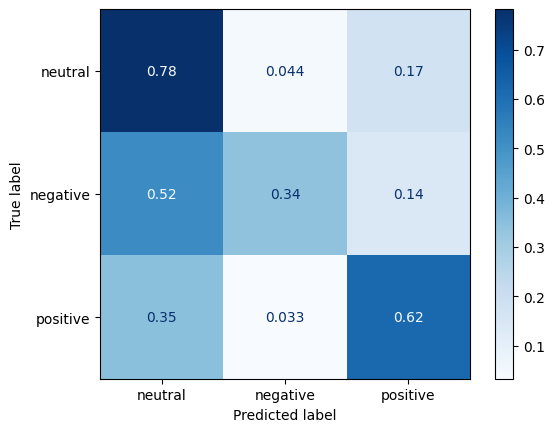

100%|██████████| 1853/1853 [00:00<00:00, 8977.27it/s]


twitter-test2.txt (SVM) F1-macro: 0.586


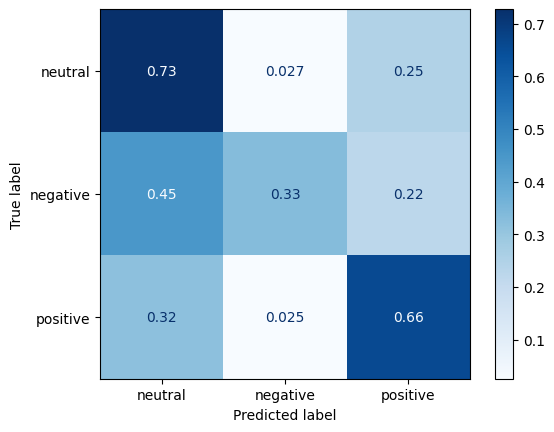

100%|██████████| 2379/2379 [00:00<00:00, 10284.27it/s]


twitter-test3.txt (SVM) F1-macro: 0.565


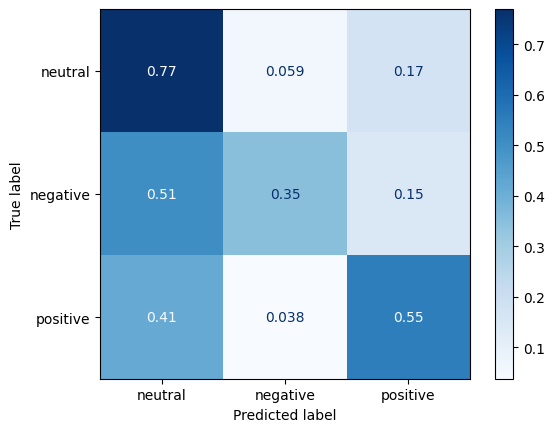

In [50]:
for test_set_index in range(numbers_of_test_sets):
    show_skeleton_results(
        test_set_index,
        predict_from_single_test_set(
            test_set_index,
            svm_atomic_predict_process
        ),
        "SVM"
    )

100%|██████████| 3531/3531 [00:00<00:00, 10877.52it/s]


twitter-test1.txt (Logistic Regression) F1-macro: 0.626


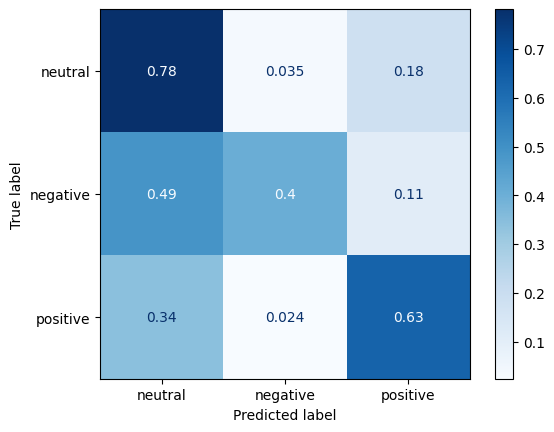

100%|██████████| 1853/1853 [00:00<00:00, 11077.59it/s]


twitter-test2.txt (Logistic Regression) F1-macro: 0.627


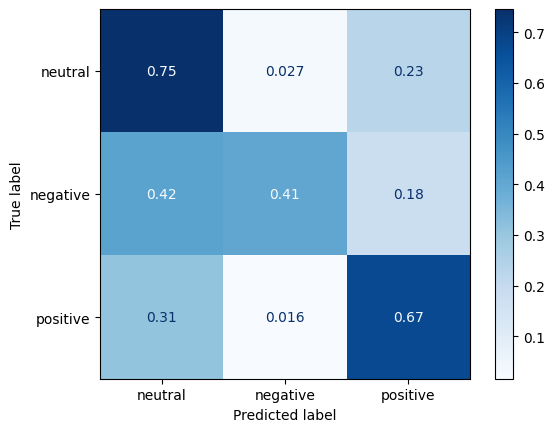

100%|██████████| 2379/2379 [00:00<00:00, 11251.68it/s]


twitter-test3.txt (Logistic Regression) F1-macro: 0.585


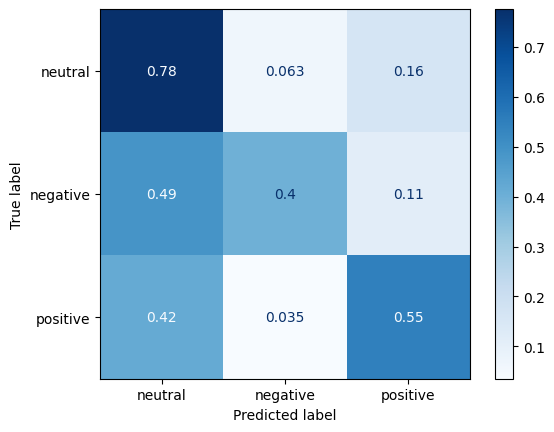

In [51]:
for test_set_index in range(numbers_of_test_sets):
    show_skeleton_results(
        test_set_index,
        predict_from_single_test_set(
            test_set_index,
            logistic_regression_atomic_predict_process
        ),
        "Logistic Regression"
    )

100%|██████████| 3531/3531 [00:04<00:00, 779.73it/s]


twitter-test1.txt (LSTM) F1-macro: 0.645


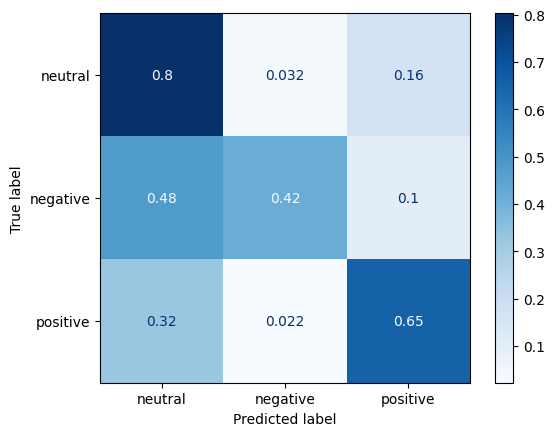

100%|██████████| 1853/1853 [00:02<00:00, 833.24it/s]


twitter-test2.txt (LSTM) F1-macro: 0.652


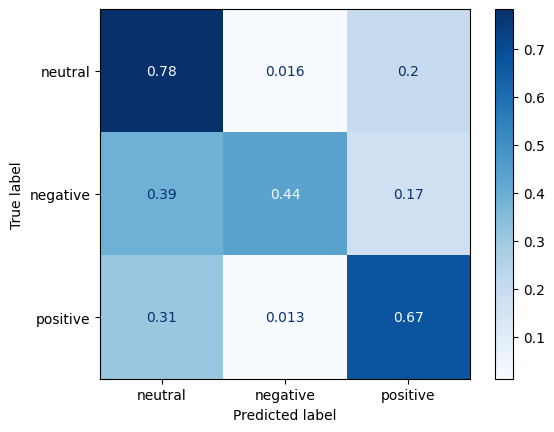

100%|██████████| 2379/2379 [00:02<00:00, 890.26it/s]


twitter-test3.txt (LSTM) F1-macro: 0.607


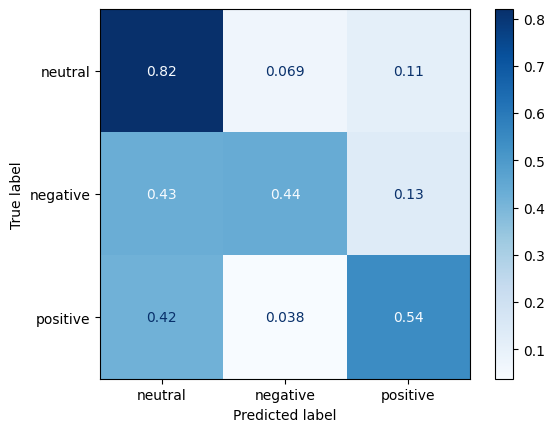

In [52]:
for test_set_index in range(numbers_of_test_sets):
    show_skeleton_results(
        test_set_index,
        predict_from_single_test_set(
            test_set_index,
            lstm_atomic_predict_process
        ),
        "LSTM"
    )

100%|██████████| 3531/3531 [00:38<00:00, 92.77it/s]


twitter-test1.txt (Fine-tuned BERT) F1-macro: 0.687


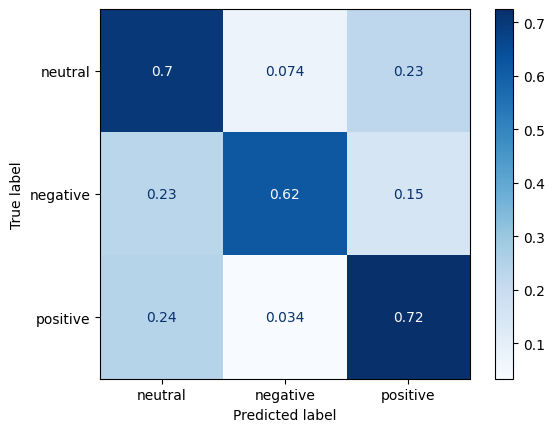

100%|██████████| 1853/1853 [00:16<00:00, 109.07it/s]


twitter-test2.txt (Fine-tuned BERT) F1-macro: 0.655


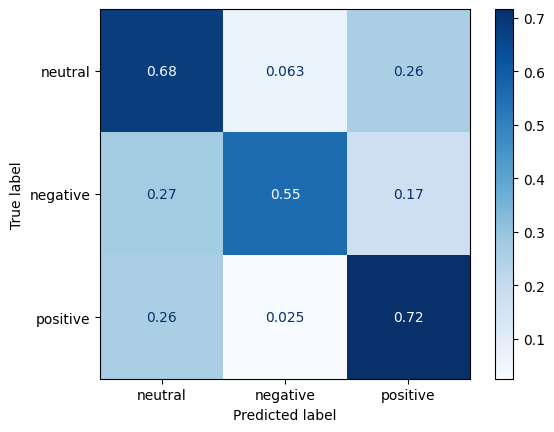

100%|██████████| 2379/2379 [00:22<00:00, 106.73it/s]


twitter-test3.txt (Fine-tuned BERT) F1-macro: 0.633


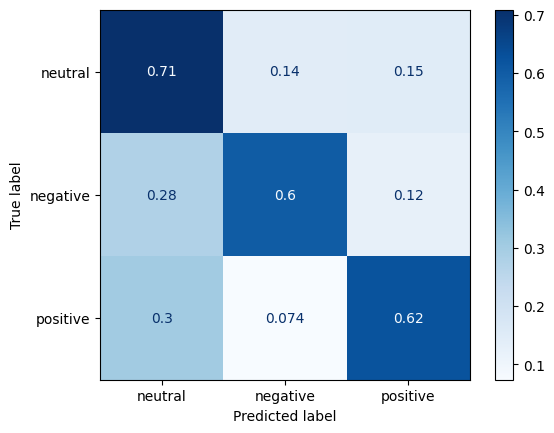

In [53]:
for test_set_index in range(numbers_of_test_sets):
    show_skeleton_results(
        test_set_index,
        predict_from_single_test_set(
            test_set_index,
            bert_atomic_predict_process
        ),
        "Fine-tuned BERT"
    )